In this notebook I'm refining what I started in the last notebook. I am looking for a better way to visualize total daily insulin along with daily CGM stats. I'm exploring a different plotting library that I haven't included here yet: [Plotly](https://plotly.com/python/). Plotly is super cool, but if you scroll down you'll see that I have not really mastered it, so I'm going back to Matplotlib and Seaborn.

## TL;DR
Also though, if you don't want to wade through the code, here's where I ended up. Alma's total insulin is shown in the top panel, split up into whether it's basal or bolus. The bottom panel shows box plots of her daily CGM values. The boxes show percentiles (25th, 50th, 75th) plus the "whiskers" showing min and max values. The gray bar in the background of the bottom panel shows her current target range, and it is between us 70 and 180. 

><div>
<img src="../assets/images/2023.03.02-plot01.jpg" width="500"/>
</div>

I know the x-axis is still sort of wack but things started looking better about 10 days ago. You may be wondering - what happened 10 days ago? A few things:

- switched her pump (Omnipod 5) to automated mode instead of manual
- started slightly tightening her carb ratios
- did more manual corrections (overrides) as needed (although once her carb ratios are right I shouldn't need so many of those). 

In [5]:
# IMPORTS

# since this notebook lives in a sub-folder of the main project, I'll add the main folder to the python path
import sys
sys.path.append("../")

# Load my module
from tools.glooko import read_all

# Load extra stuff that I need
import numpy as np
import pandas as pd

# Plotting (matplotlib widge allows for interactivity in the live notebook)
import matplotlib.pyplot as plt
%matplotlib widget


In [6]:
# GET UNIQUE DAYS

# I added a new module, stats.py, to the tools package. So far it 
# contains a function to extract unique days
from tools.stats import get_yeardays

df_cgm, df_bolus, df_basal, df_insulin = read_all(r"../data")
df_cgm["yearday"] = get_yeardays(df_cgm)
df_insulin["yearday"] = get_yeardays(df_insulin)

# COMPUTE STATS PER DAY
df_cgm.drop("sn_cgm", axis=1, inplace=True)
df_cgm_summary = df_cgm[["bg", "yearday"]].groupby("yearday").describe()["bg"]


df_cgm_summary["yearday"] = df_cgm_summary.index
df_cgm_summary["time"] = pd.to_datetime(df_cgm_summary['yearday'], format='%Y-%j')

## Plotting daily BGs and insulin summaries using Plotly

In this next plot I'm just trying to put daily blood glucose and insulin summaries together in a way that I can try to see patterns. (as an aside I am also using plotly - it seems to take more lines of code but is still kind of easy and makes interactive plots). 

This is not a great plot. I know what I'm looking for so I can kind of see it, but it's not super clear. I know that in the last few days of the time series, I increased insulin and worked harder on small adjustments to get what I wanted. (e.g., I was pretty determined not to have BG's hitting high 300s every day.) You can BARELY see that in this plot. 

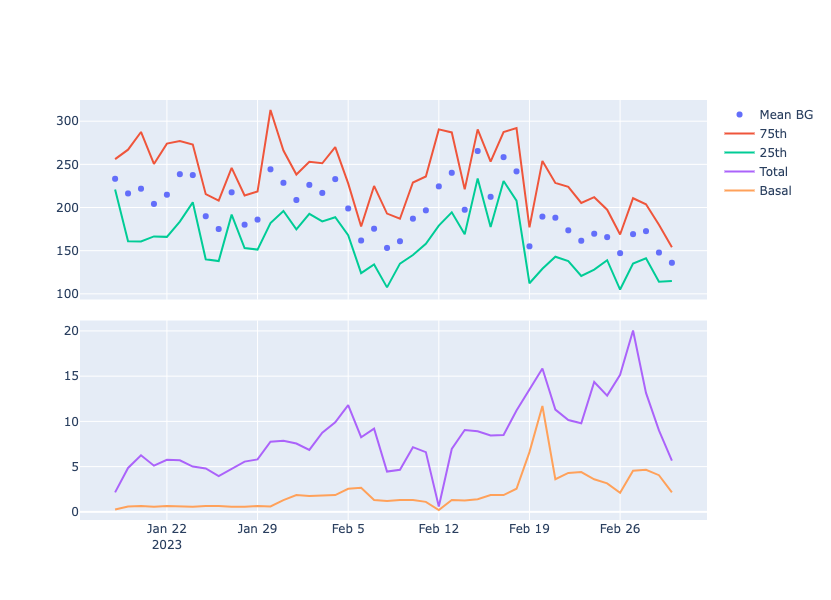

In [7]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots


fig = make_subplots(rows=2, cols=1, vertical_spacing = 0.05)

fig.add_trace(go.Scatter(
    name="Mean BG",
    mode="markers", x=df_cgm_summary["time"], y=df_cgm_summary["mean"]
), row=1, col=1)

fig.add_trace(go.Scatter(
    name="75th",
    mode="lines", x=df_cgm_summary["time"], y=df_cgm_summary["75%"],
), row=1, col=1)

fig.add_trace(go.Scatter(
    name="25th",
    mode="lines", x=df_cgm_summary["time"], y=df_cgm_summary["25%"],
), row=1, col=1)

fig.add_trace(go.Scatter(
    name="Total",
    mode="lines", x=df_insulin["time"], y=df_insulin["total_insulin"],
), row=2, col=1)

fig.add_trace(go.Scatter(
    name="Basal",
    mode="lines", x=df_insulin["time"], y=df_insulin["total_basal"],
), row=2, col=1)

fig.update_layout(height=600)

fig.update_xaxes(showticklabels=False) # hide all the xticks
fig.update_xaxes(showticklabels=True, row=2, col=1)

fig.update_xaxes(matches='x')

fig.show()

## Back to seaborn

I'm sure that I could do amazing things with plotly, but I'm not really there yet. Yes, it's nice to have interactive plots, but I'm not seeing anything particularly useful yet. 

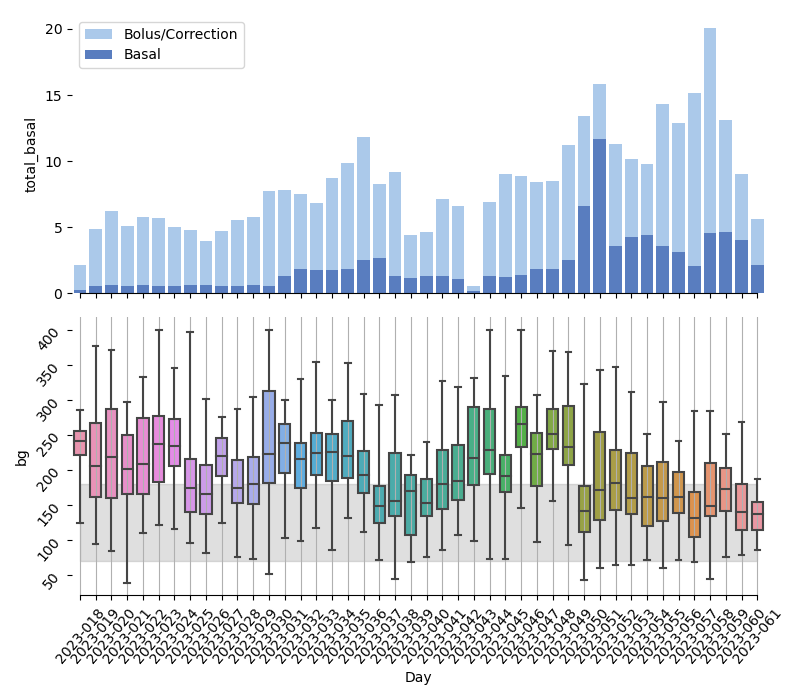

In [8]:
import seaborn as sns
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(2,1,figsize=(8, 7), sharex=True)

# Plot the insulin
sns.set_color_codes("pastel")
sns.barplot(x="time", y="total_insulin", data=df_insulin,
            label="Bolus/Correction", color="b", ax=ax[0])

# Plot the basal 
sns.set_color_codes("muted")
sns.barplot(x="yearday", y="total_basal", data=df_insulin,
            label="Basal", color="b", ax=ax[0])

# Add a legend and informative axis label
ax[0].legend(ncol=1, frameon=True)
sns.despine(left=True, bottom=True,ax=ax[0])

# BOX PLOTS
sns.boxplot(x="yearday", y="bg",data=df_cgm,
            whis=[0, 100], width=.7, ax=ax[1])

# Add rectangle
xmin = ax[1].get_xticks()[0]
xmax = ax[1].get_xticks()[-1]
goal_range = Rectangle((xmin, 70),xmax-xmin, 180-70, color ='gray', alpha=0.25,zorder=0)
ax[1].add_patch(goal_range)

ax[1].xaxis.grid(True)
sns.despine(trim=True, left=True)

ax[0].set_xlabel("")
ax[1].set_xlabel("Day")
ax[1].tick_params(rotation=50)
ax[1].invert_xaxis()


fig.tight_layout()